# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [193]:
# stundent details Itay F. 3317: 

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>




    
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [194]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [195]:
sf_lat, sf_lon = 37.7749, -122.4194 # Coordinates for San Francisco
la_lat, la_lon = 34.0522, -118.2436 # Coordinates for Los Angeles
sd_lat, sd_lon = 32.7157, -117.1611 # Coordinates for San Diego
sj_lat, sj_lon = 37.3382, -121.8863 # Coordinates for San Jose

In [196]:
def load_csv( dest, IfPrint ):
    df = pd.read_csv(dest)
    if IfPrint == True:
        print("First rows of set:")
        print(df.head())
    
    return df

In [197]:
def validate_data( df ):
    # Check for missing values
    if df.isnull().sum() == 0:
        return True
    return False

In [198]:
def printHistplot(title, df, colName):
    sns.histplot(df[colName], kde=True)
    plt.title(title)
    plt.show()

In [199]:
def printBoxPlot(title, df, colName):
    sns.boxplot(x=df[colName])
    plt.title(title)
    plt.show()

In [200]:
def printFeatureCorrelation(title, df, features = None):
    if features == None:
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm',fmt=".2f", linewidths=0.5)
    else:
        sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm',fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.show()

In [201]:
def printScatterPlot(title, df, xColName, yColName, zColName):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df[xColName],
        y=df[yColName],
        hue=df[zColName],
        palette='viridis',
        data=df,
        alpha=0.6
    )
    plt.title(title)
    plt.xlabel(xColName)
    plt.ylabel(yColName)
    plt.legend(title=zColName, loc='upper right')
    plt.show()

In [202]:
def euclidean_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

In [203]:
def add_location_clusters(df, n_clusters=10):
    coords = df[['Latitude', 'Longitude']]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
    df['location_cluster'] = kmeans.predict(coords)
    df = pd.get_dummies(df, columns=['location_cluster'], drop_first=True)
    return df


In [204]:
def distance_featuring(df):
    # dist to big cities
    df['dist_sf'] = euclidean_distance(df['Latitude'], df['Longitude'], sf_lat, sf_lon)
    df['dist_la'] = euclidean_distance(df['Latitude'], df['Longitude'], la_lat, la_lon)
    df['dist_sd'] = euclidean_distance(df['Latitude'], df['Longitude'], sd_lat, sd_lon)
    df['dist_sj'] = euclidean_distance(df['Latitude'], df['Longitude'], sj_lat, sj_lon)

    # dist to closest city
    df['min_dist_to_city'] = df[['dist_sf', 'dist_la', 'dist_sd', 'dist_sj']].min(axis=1)
    return df

In [205]:
def engineer_features(df): 
    # Distance to big cities
    df = distance_featuring(df)
    # df = add_location_clusters(df)

    df['room_bedroom_rat'] =df['AveRooms'] / df['AveBedrms']
    df['income_room_interaction'] = df['MedInc'] * df['room_bedroom_rat']
    df['income_distance_interaction'] = df['MedInc'] * df['min_dist_to_city']
    
    return df

In [206]:
def feature_scaling(df, features_to_scale, scaler):  
    if scaler == None:
        scaler =  StandardScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    
    return df

In [207]:
def train_model(df, features, target, model):
    X_train = df[features]
    y_train = df[target]

    # model = LinearRegression()
    model.fit(X_train, y_train)
    return model

In [208]:
def test_model( model, X_train, Y_train, cvVal=5, scoringVal='r2'):
    scores = cross_val_score(model, X_train, Y_train, cv = cvVal, scoring = scoringVal)

    print("R² scores for each fold:", scores)
    print("Average R² score:", scores.mean())

In [229]:
def grid_train_model(X_train, Y_train ):

    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7]
    }

    grid_search = GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, Y_train)
    best_model = grid_search.best_estimator_

    return best_model

In [210]:
def predict(df, features, target, model):
    X_test = df[features]
    y_test = df[target]

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")

## Part 3 - Experiments
You could add as many code cells as needed

In [211]:
df_train = load_csv("housing_train.csv", True )
print("\n")
df_test = load_csv("housing_test.csv", True )

First rows of set:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  4.0179      46.0  4.158690   1.032746       512.0  1.289673     34.07   
1  2.7002       6.0  4.149245   1.179989      4092.0  2.287311     34.05   
2  1.2762      17.0  3.432331   1.022556      1325.0  2.490602     34.42   
3  4.9342      23.0  5.735798   1.053201      4580.0  4.129847     34.04   
4  2.2755      21.0  4.064607   0.962079      2109.0  2.962079     32.58   

   Longitude  MedHouseVal  
0    -118.35        3.500  
1    -117.31        0.883  
2    -119.69        2.536  
3    -117.93        1.810  
4    -117.11        1.250  


First rows of set:
   MedInc  HouseAge   AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  5.3254      32.0   5.786260   1.033079       982.0  2.498728     34.29   
1  5.3032      52.0   5.095745   1.028369       980.0  3.475177     34.08   
2  4.1679      41.0   6.617486   1.371585       915.0  2.500000     37.05   
3  3.6429      28.0   5.249

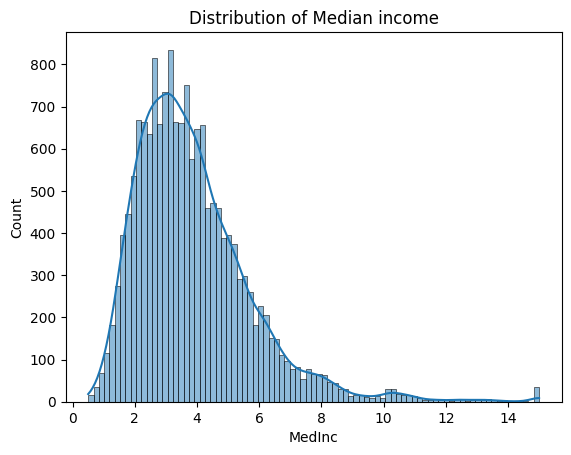

In [212]:
printHistplot("Distribution of Median income", df_train,"MedInc")

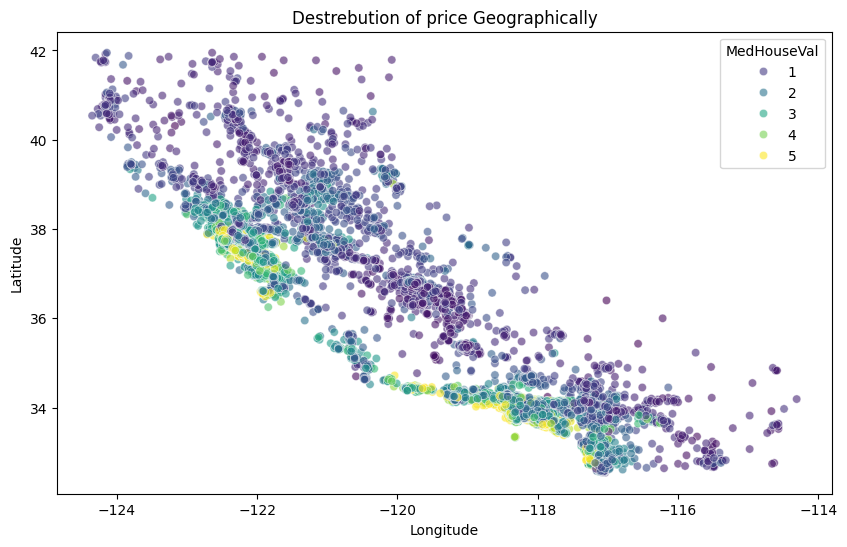

In [213]:
printScatterPlot("Destrebution of price Geographically", df_train, "Longitude","Latitude","MedHouseVal" )

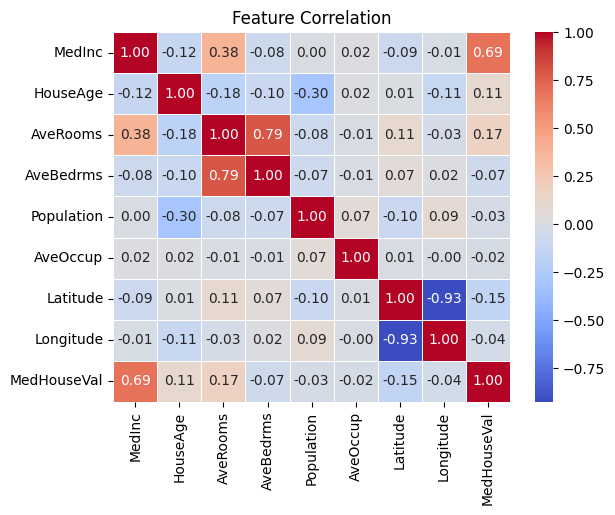

In [214]:
printFeatureCorrelation("Feature Correlation",df_train)

In [215]:
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

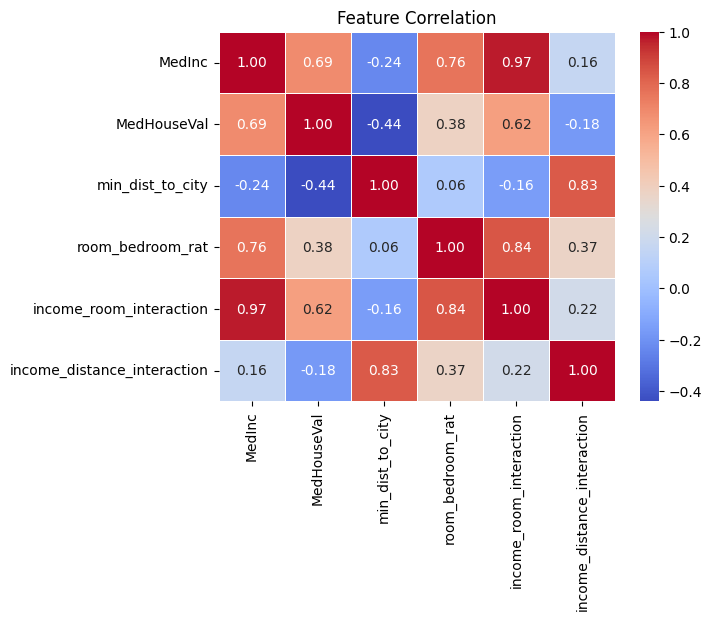

In [216]:
features = ["MedInc",
            # "AveRooms",
            # "AveBedrms",
            # "Latitude",
            # "Longitude",
            "MedHouseVal",
            "min_dist_to_city",
            "room_bedroom_rat",
            "income_room_interaction",
            "income_distance_interaction"
            ]
printFeatureCorrelation("Feature Correlation",df_train, features)

In [217]:
scaler = MinMaxScaler()
features = [
    'min_dist_to_city',
    'room_bedroom_rat',
    'MedInc',
    # 'AveRooms',
    # 'AveBedrms',
    'income_room_interaction',
    'income_distance_interaction']

df_train = feature_scaling(df_train, features, scaler)
df_test = feature_scaling(df_test, features, scaler)

In [218]:
## Test different models

features_to_train = [
    'min_dist_to_city',
    # 'room_bedroom_rat',
    'MedInc',
    'AveRooms',
    'AveBedrms',
    # 'income_room_interaction',
    'income_distance_interaction']
X_train = df_train[features_to_train]
Y_train = df_train['MedHouseVal']

model = LinearRegression()
test_model(model, X_train, Y_train) 

R² scores for each fold: [0.58501241 0.56975231 0.54676419 0.57612322 0.55567887]
Average R² score: 0.5666662002513148


In [219]:
features_to_train = [
    'min_dist_to_city',
    'room_bedroom_rat',
    'MedInc',
    # 'AveRooms',
    # 'AveBedrms',
    'income_room_interaction',
    'income_distance_interaction']
X_train = df_train[features_to_train]
Y_train = df_train['MedHouseVal']

model = LinearRegression()
test_model(model, X_train, Y_train) 

R² scores for each fold: [0.58821989 0.58007424 0.5531555  0.58030396 0.55809971]
Average R² score: 0.5719706620316803


In [221]:
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    random_state=42 )

test_model(model, X_train, Y_train) 

R² scores for each fold: [0.64691886 0.64301876 0.61395245 0.62515055 0.61122692]
Average R² score: 0.6280535085008749


In [222]:
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42 )

test_model(model, X_train, Y_train) 

R² scores for each fold: [0.63151277 0.62325424 0.59532862 0.61611585 0.6076686 ]
Average R² score: 0.6147760177730218


In [223]:
model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42 )

test_model(model, X_train, Y_train) 

R² scores for each fold: [0.64596143 0.64726892 0.61296569 0.62891197 0.61417323]
Average R² score: 0.629856247654521


In [230]:
model = grid_train_model(X_train, Y_train)
test_model(model, X_train, Y_train) 

R² scores for each fold: [0.64596143 0.64726892 0.61296569 0.62891197 0.61417323]
Average R² score: 0.629856247654521


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [232]:
trained_model = train_model(df_train,features_to_train,'MedHouseVal',model)

## Part 5 - Apply on test and show model performance estimation

In [233]:
predict(df_test,features_to_train,'MedHouseVal',model)

Mean Squared Error: 0.48
R² Score: 0.65
